In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# This will reload imports before executing code, allowing you to easily change contents of custom scripts
%load_ext autoreload
%autoreload 2

# Stay classification: cluster-splitting with box-refinement & shifting boxes

For current list of general ideas, etc. see `README_canonical_stays.md`

## Notes: 

* **Gaps** 
    * since there are subclusters for a given cluster which are separated by gaps, these gaps ...

### 1-stay
* gap-merging works well when good density; poorly when otherwise


In [3]:
import numpy as np
import pandas as pd

In [4]:
import os, sys
sys.path.append('/home/sandm/Notebooks/stay_classification/src/')

In [5]:
# #############################################################################
%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, 10)]

from random import shuffle

In [7]:
shuffle(colors)

# Sythetic data

In [8]:
from synthetic_data.trajectory import get_stay_segs, get_adjusted_stays
from synthetic_data.trajectory_class import get_rand_traj
from synthetic_data.plotting import plot_trajectory, add_plot_seg_boxes

from synthetic_data.trajectory_class import get_trajectory
from synthetic_data.trajectory import get_stay

dsec = 1/3600.0
t_total = np.arange(0,24,dsec)

In [9]:
from synthetic_data.canonical_stays import get1, get2, get3e, get3, get3_core, gen_stays

In [11]:
from stay_classification.splitting_classifier.splitting_classifier import get_clusters

In [37]:
from helper__metric_box__explore import iqr_metrics, get_boxplot_quants, get_clusters_rev, get_boxplot_centers, get_iqr_mask, get_clusters_x

In [62]:
event_frac = 0.001#rand_range(1,0.01,0.001)[0]
duplicate_frac = 0.0 #rand_range(1,0.3,0.05)[0]

configs = {
    'time_thresh':1/6,
    'dist_thresh':0.5,
    'event_frac':event_frac,
    'duplicate_frac':duplicate_frac,    
    'noise_min':0.02,
    'noise_max':0.15
}

stays = get1()

# Clustering

In [91]:
def get_temporal_density(t_arr, time_step):
    
    time_window = 1.0
    
    get_event_count = lambda timepoint: np.where( (t_arr >= timepoint) & (t_arr < timepoint+time_window))[0].size
    
    t_start = t_arr[0]
    t_end = t_arr[-1]
    
    total_duration = t_end - t_start
    
    event_counts = []
    
    window = t_start
    while window+time_window < t_end:
        
        event_counts.append(get_event_count(window))
        
        window += time_step
        
    print(f"avg.: {sum(event_counts)/len(event_counts):5.3f} counts/hr")

In [93]:
time_thresh = 1/6
dist_thresh=0.125

avg.: 3.234 counts/hr
2 forward clusters
1 backward clusters


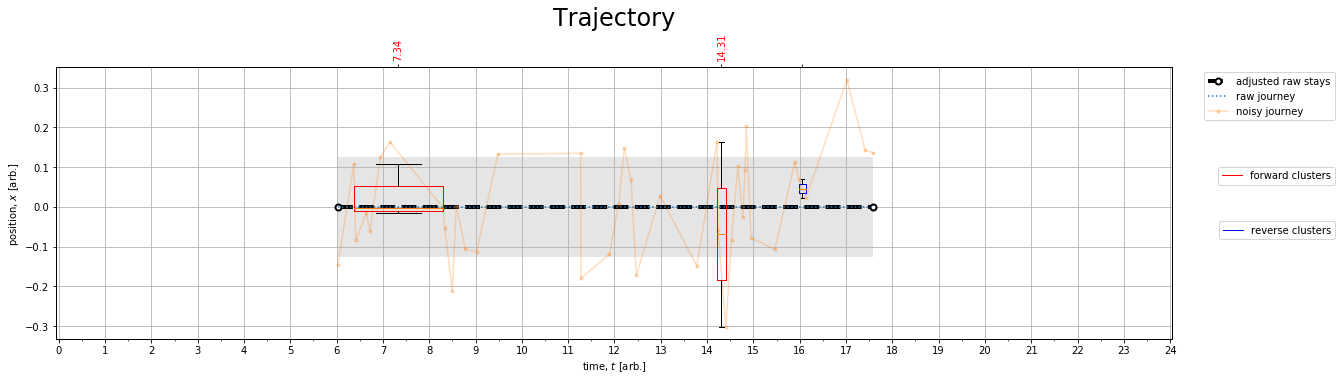

In [94]:
time_arr, raw_arr, noise_arr, segments = get_trajectory(stays, t_total, configs)
t_segs, x_segs = get_stay_segs(get_adjusted_stays(segments, time_arr))


'''plt.figure(figsize=(20,10))
ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);''';

ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);
add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)

get_temporal_density(time_arr, time_thresh)

clusters = get_clusters_x(time_arr, noise_arr, dist_thresh, time_thresh)


if len(clusters) > 0:
    print(len(clusters), 'forward clusters')
    bp_data, labels, positions, widths = get_boxplot_quants(time_arr, noise_arr, clusters)

    axt = ax.twiny()
    _ = axt.boxplot(bp_data, labels=labels, positions=positions, boxprops=dict(color='red'), widths=widths)   

    for label in axt.get_xticklabels():
        label.set_rotation(90)
    axt.set_xticklabels(labels, visible=True, color='red')


    axt.set_xlim(ax.get_xlim())
    axt.legend(['forward clusters'], bbox_to_anchor=(1.15, 0.6), loc='center right', ncol=1);
else:
    print('No forward clusters')


clusters_rev = get_clusters_x(time_arr[::-1], noise_arr[::-1], dist_thresh, time_thresh)
    
if len(clusters_rev) > 0:
    print(len(clusters_rev), 'backward clusters')    
    bp_data, labels, positions, widths = get_boxplot_quants(time_arr[::-1], noise_arr[::-1], clusters_rev)

    axt = ax.twiny()
    labels = list(map(lambda x: f"{x:.2f}", positions))
    _ = axt.boxplot(bp_data, labels=labels, positions=positions, boxprops=dict(color='blue'), widths=widths)
    axt.legend(['reverse clusters'], bbox_to_anchor=(1.15, 0.4), loc='center right', ncol=1);

    for label in axt.get_xticklabels():
        label.set_rotation(90)

    axt.set_xticklabels(labels, visible=False)

    axt.set_xlim(ax.get_xlim())
else:
    print('No backward clusters')
    
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right', ncol=1);

In [16]:
from helper__metric_box__explore import eval_synth_data

In [44]:
prec, rec, conmat = eval_synth_data(segments, time_arr, clusters)
print('forward')
print(f"{prec:6.3f}")
print(f"{ rec:6.3f}")
print(conmat)
print()
prec, rec, conmat = eval_synth_data(segments, time_arr, clusters_rev)
print('backward')
print(f"{prec:6.3f}")
print(f"{ rec:6.3f}")
print(conmat)

forward
 1.000
 0.820
[[  0   0]
 [ 78 355]]

backward
 1.000
 0.831
[[  0   0]
 [ 73 360]]


## Development

In [18]:
from helper__gaps import merge_clusters

In [19]:
from helper__metric_box__explore import get_cluster_boxplot, kwargs_filled, kwargs_unfilled

### Early gap-method

2
2


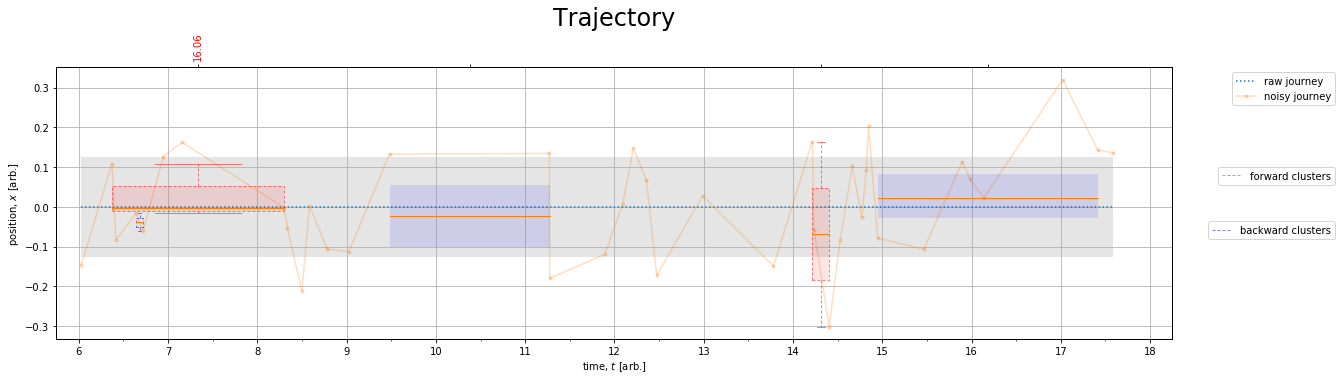

In [95]:
ax = plot_trajectory(time_arr, raw_arr, noise_arr, None, None, configs['dist_thresh']);
add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)

ax.set_xlim([5.75,18.25])

axt = ax.twiny()

kwargs_unfilled['color'] = 'red'
kwargs_unfilled['legend_label'] = 'forward clusters'
kwargs_unfilled['bbox_tuple'] = (1.15, 0.6)

kwargs_filled['color'] = 'red'
kwargs_filled['legend_label'] = None
kwargs_filled['bbox_tuple'] = (1.15, 0.6)

axt = get_cluster_boxplot(clusters, time_arr, noise_arr, axt, **kwargs_unfilled)

new_clusters = merge_clusters(time_arr, noise_arr, clusters, dist_thresh, 3*time_thresh)
print(len(new_clusters))
axt = get_cluster_boxplot(new_clusters, time_arr, noise_arr, axt, **kwargs_filled)

for label in axt.get_xticklabels():
    label.set_rotation(90)
axt.set_xticklabels(labels, visible=True, color='red')
axt.set_xlim(ax.get_xlim())


axt = ax.twiny()

kwargs_unfilled['color'] = 'blue'
kwargs_unfilled['legend_label'] = 'backward clusters'
kwargs_unfilled['bbox_tuple'] = (1.15, 0.4)

kwargs_filled['color'] = 'blue'
kwargs_filled['legend_label'] = None
kwargs_filled['bbox_tuple'] = (1.15, 0.4)

axt = get_cluster_boxplot(clusters_rev, time_arr, noise_arr, axt, **kwargs_unfilled)

new_clusters_rev = merge_clusters(time_arr[::-1], noise_arr[::-1], clusters, dist_thresh, 3*time_thresh)
print(len(new_clusters_rev))
axt = get_cluster_boxplot(new_clusters_rev, time_arr[::-1], noise_arr[::-1], axt, **kwargs_filled)

for label in axt.get_xticklabels():
    label.set_rotation(90)    
axt.set_xticklabels(labels, visible=False)
axt.set_xlim(ax.get_xlim())


ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right', ncol=1);

In [96]:
prec, rec, conmat = eval_synth_data(segments, time_arr, new_clusters)
print('forward')
print(f"{prec:6.3f}")
print(f"{ rec:6.3f}")
print(conmat)
print()
prec, rec, conmat = eval_synth_data(segments, time_arr, new_clusters_rev)
print('backward')
print(f"{prec:6.3f}")
print(f"{ rec:6.3f}")
print(conmat)

forward
 1.000
 0.256
[[ 0  0]
 [29 10]]

backward
 1.000
 0.256
[[ 0  0]
 [29 10]]


### Later gap method

In [22]:
from helper__gaps import get_intercluster_metrics

In [97]:
for c1,c2 in zip(clusters[:-1],clusters[1:]):
    
    gap_time, min_allowed, x_med = get_intercluster_metrics(c1, c2, time_arr, noise_arr, time_thresh, 3.4)
    
    print(f"{gap_time:5.3f}, {min_allowed:5.3f}", 
          gap_time < min_allowed, 
          f"\t{np.median(noise_arr[c1]):7.3f} {x_med:7.3f} {np.median(noise_arr[c2]):7.3f}", 
          f"\t{abs(np.median(noise_arr[c1])-x_med):7.3f} {abs(np.median(noise_arr[c2])-x_med):7.3f}")

5.916, 0.186 False 	 -0.002  -0.002  -0.068 	  0.000   0.066


In [98]:
from helper__gaps import merge_cluster_pair, gap_criterion_2, merge_clusters_2

In [99]:
[gap_criterion_2(dist_thresh, time_thresh)(time_arr,noise_arr,c1,c2) for c1, c2 in zip(clusters[:-1],clusters[1:])]

[True]

In [100]:
new_clusters_2 = merge_clusters_2(time_arr, noise_arr, clusters, dist_thresh, time_thresh, 3.5, True)

[True] 
 ['0.066'] 
 0
[]


1
1


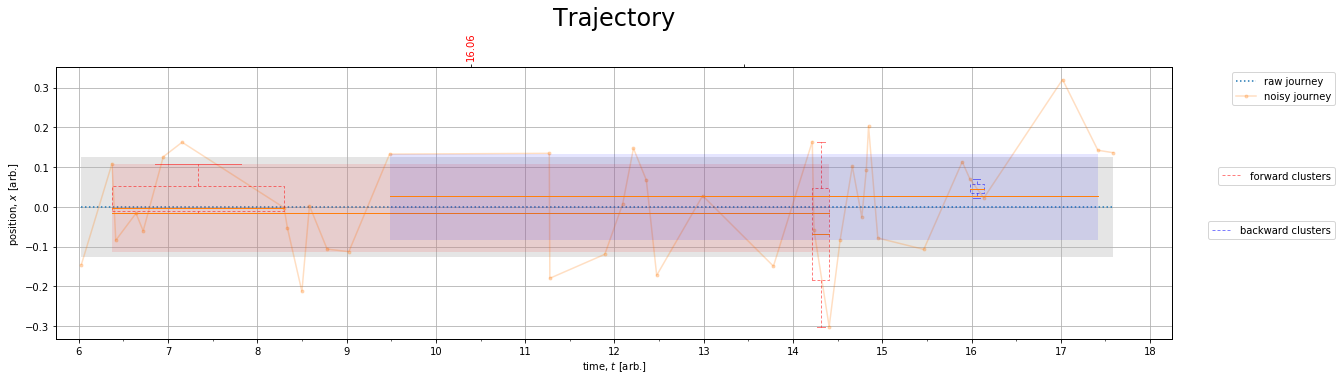

In [103]:
ax = plot_trajectory(time_arr, raw_arr, noise_arr, None, None, configs['dist_thresh']);
add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)

ax.set_xlim([5.75,18.25])

axt = ax.twiny()

kwargs_unfilled['color'] = 'red'
kwargs_unfilled['legend_label'] = 'forward clusters'
kwargs_unfilled['bbox_tuple'] = (1.15, 0.6)

kwargs_filled['color'] = 'red'
kwargs_filled['legend_label'] = None
kwargs_filled['bbox_tuple'] = (1.15, 0.6)

axt = get_cluster_boxplot(clusters, time_arr, noise_arr, axt, **kwargs_unfilled)

new_clusters_2 = merge_clusters_2(time_arr, noise_arr, clusters, dist_thresh, time_thresh)
print(len(new_clusters_2))
axt = get_cluster_boxplot(new_clusters_2, time_arr, noise_arr, axt, **kwargs_filled)

for label in axt.get_xticklabels():
    label.set_rotation(90)
axt.set_xticklabels(labels, visible=True, color='red')
axt.set_xlim(ax.get_xlim())


axt = ax.twiny()

kwargs_unfilled['color'] = 'blue'
kwargs_unfilled['legend_label'] = 'backward clusters'
kwargs_unfilled['bbox_tuple'] = (1.15, 0.4)

kwargs_filled['color'] = 'blue'
kwargs_filled['legend_label'] = None
kwargs_filled['bbox_tuple'] = (1.15, 0.4)

axt = get_cluster_boxplot(clusters_rev, time_arr[::-1], noise_arr[::-1], axt, **kwargs_unfilled)
new_clusters_rev_2 = merge_clusters_2(time_arr[::-1], noise_arr[::-1], clusters, dist_thresh, time_thresh)
print(len(new_clusters_rev2))
axt = get_cluster_boxplot(new_clusters_rev_2, time_arr[::-1], noise_arr[::-1], axt, **kwargs_filled)

for label in axt.get_xticklabels():
    label.set_rotation(90)    
axt.set_xticklabels(labels, visible=False)
axt.set_xlim(ax.get_xlim())


ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right', ncol=1);

In [28]:
from helper__gaps import merge_cluster_pair, get_gap_dist

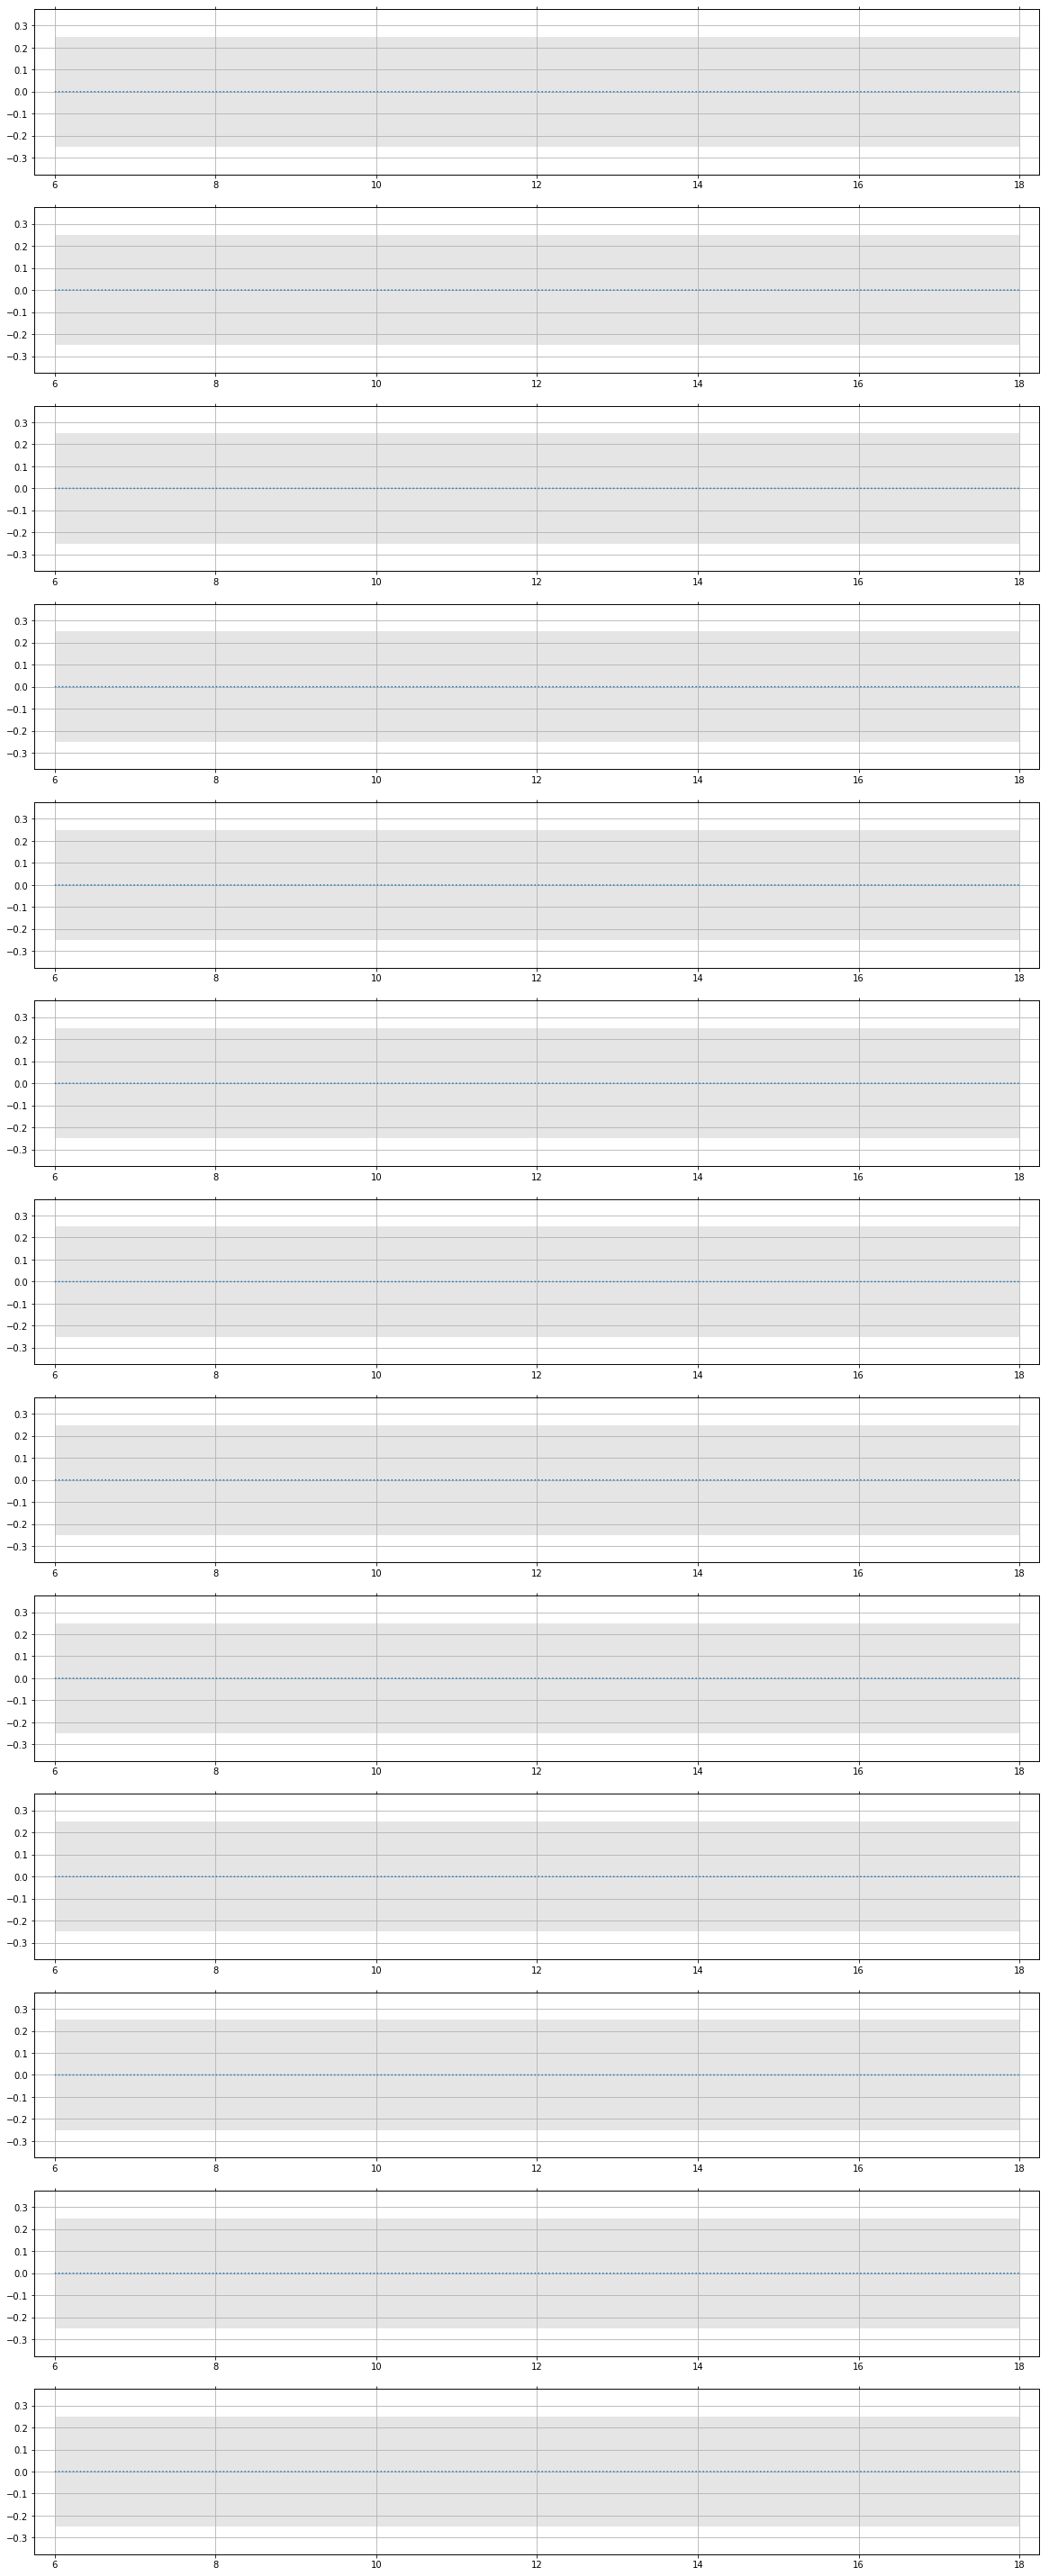

In [29]:
nnn = 13

fig, axs = plt.subplots(nnn,1,figsize=[20,4*nnn])

axs = axs.flatten()

new_clusters2 = clusters.copy()

for n in range(nnn):
    
    ax = axs[n]
    #ax = plot_trajectory(time_arr, raw_arr, noise_arr, None, None, configs['dist_thresh']);
    ax.plot(time_arr, raw_arr, "C0:")    
    add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)

    ax.set_xlim([5.75,18.25])
    
    ymax = raw_arr.max()+1.5*dist_thresh
    
    ax.set_ylim([-ymax,ymax])
    
    try:
        axt = ax.twiny()

        gaps = [gap_criterion_2(dist_thresh, time_thresh)(time_arr,noise_arr,c1,c2) for c1, c2 in zip(new_clusters2[:-1],new_clusters2[1:])]     
        dists = [get_gap_dist(noise_arr,c1,c2) for c1, c2 in zip(new_clusters2[:-1],new_clusters2[1:])]

        gaps_add = np.array([100*int(not g) for g in gaps])
        dists_add = np.array(dists)+gaps_add

        min_index = np.argmin(dists_add)

        new_clusters2 = merge_cluster_pair(new_clusters2, min_index).copy()

        for c1,c2 in zip(new_clusters2[:-1],new_clusters2[1:]):

            gtime, allowed, x_med = get_intercluster_metrics(c1, c2, time_arr, noise_arr, time_thresh)

            print(f"{gtime:5.3f}, {allowed:5.3f}", 
                  gtime>allowed, 
                  f"\t{np.median(noise_arr[c1]):7.3f} {x_med:7.3f} {np.median(noise_arr[c2]):7.3f}",
                  f"\t{abs(np.median(noise_arr[c1] - x_med)):7.3f} {abs(np.median(noise_arr[c2] - x_med)):7.3f}")
        print('\n\n')   
        axt = get_cluster_boxplot(new_clusters2, time_arr, noise_arr, axt, **kwargs_unfilled)
    except: pass

    for label in axt.get_xticklabels():
        label.set_rotation(90)
    axt.set_xticklabels(labels, visible=True, color='red')
    axt.set_xlim(ax.get_xlim())

    ax.grid()
    #ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right', ncol=1);    


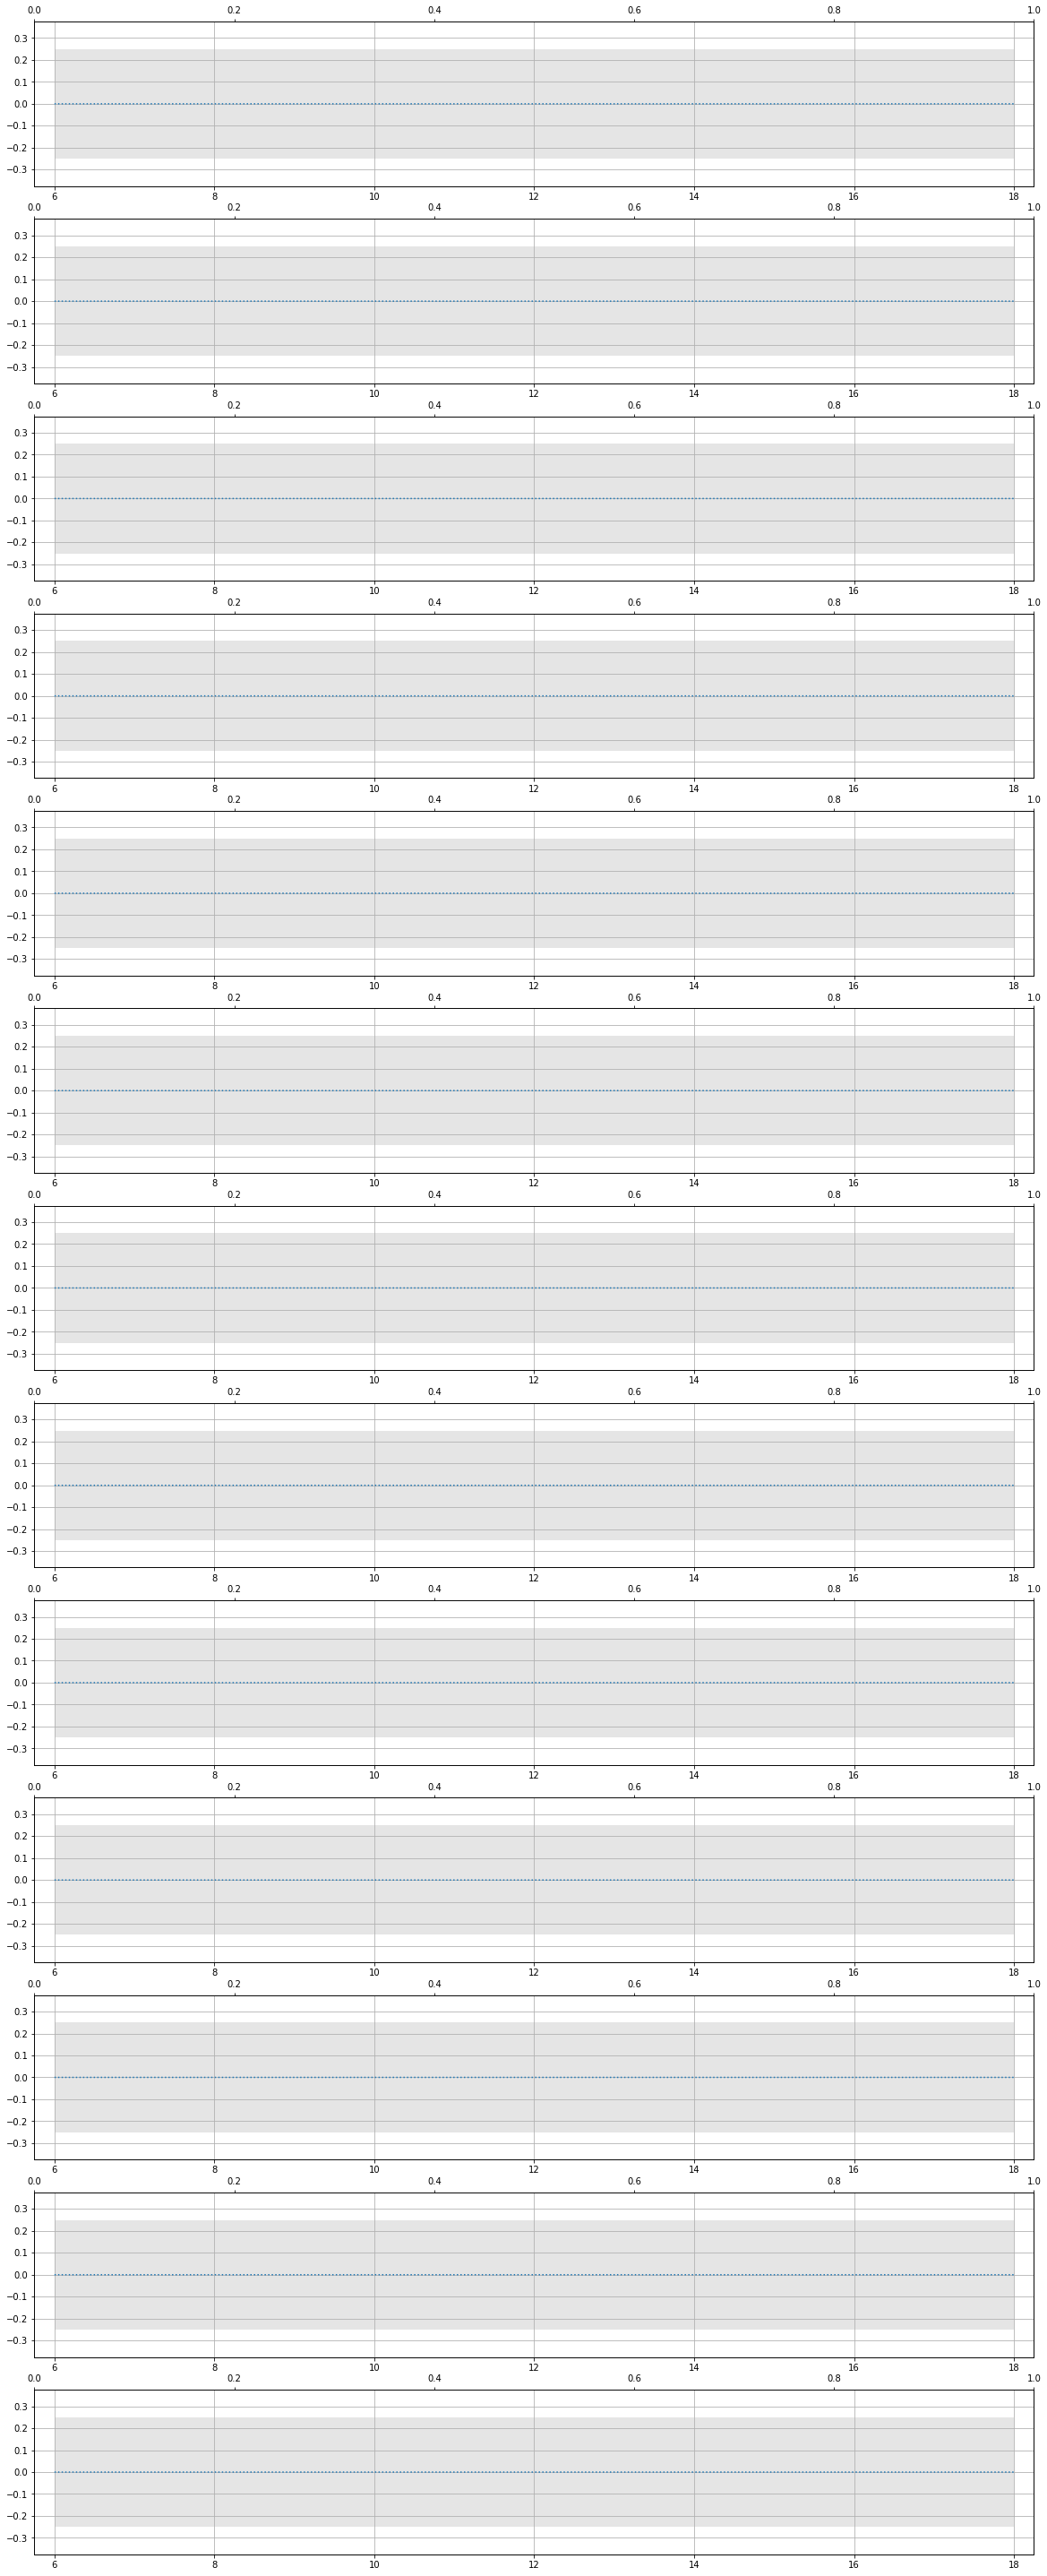

In [30]:
nnn = 13

fig, axs = plt.subplots(nnn,1,figsize=[20,4*nnn])

axs = axs.flatten()

new_clusters_rev2 = clusters_rev.copy()

for n in range(nnn):
    
    ax = axs[n]
    #ax = plot_trajectory(time_arr, raw_arr, noise_arr, None, None, configs['dist_thresh']);
    ax.plot(time_arr, raw_arr, "C0:")
    add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)

    ax.set_xlim([5.75,18.25])
    
    ymax = raw_arr.max()+1.5*dist_thresh
    
    ax.set_ylim([-ymax,ymax])
    
    try:
        axt = ax.twiny()


        gaps = [gap_criterion_2(dist_thresh, time_thresh)(time_arr[::-1],noise_arr[::-1],c1,c2) for c1, c2 in zip(new_clusters_rev2[:-1],new_clusters_rev2[1:])]     
        dists = [get_gap_dist(noise_arr[::-1],c1,c2) for c1, c2 in zip(new_clusters_rev2[:-1],new_clusters_rev2[1:])]

        gaps_add = np.array([100*int(not g) for g in gaps])
        dists_add = np.array(dists)+gaps_add

        min_index = np.argmin(dists_add)

        new_clusters_rev2 = merge_cluster_pair(new_clusters_rev2, min_index).copy()

        for c1,c2 in zip(new_clusters_rev2[:-1],new_clusters_rev2[1:]):

            gtime, allowed, x_med = get_intercluster_metrics(c1, c2, time_arr[::-1], noise_arr[::-1], time_thresh)

            print(f"{gtime:5.3f}, {allowed:5.3f}", 
                  gtime>allowed, 
                  f"\t{np.median(noise_arr[::-1][c1]):7.3f} {x_med:7.3f} {np.median(noise_arr[::-1][c2]):7.3f}",
                  f"\t{abs(np.median(noise_arr[::-1][c1] - x_med)):7.3f} {abs(np.median(noise_arr[::-1][c2] - x_med)):7.3f}")
        print('\n\n')   
        axt = get_cluster_boxplot(new_clusters_rev2, time_arr, noise_arr, axt, **kwargs_unfilled)


        for label in axt.get_xticklabels():
            label.set_rotation(90)
        axt.set_xticklabels(labels, visible=True, color='red')
        axt.set_xlim(ax.get_xlim())

    except: pass
    
    ax.grid()
    #ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right', ncol=1);    
